In [271]:
import yfinance as yf
import pandas as pd
import os

In [272]:
sp500 = yf.Ticker("^GSPC")

In [273]:
sp500 = sp500.history(period="max")

In [274]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-17 00:00:00-04:00,5635.600098,5703.520020,5631.120117,5675.120117,5031770000,0.0,0.0
2025-03-18 00:00:00-04:00,5654.529785,5654.529785,5597.759766,5614.660156,4666270000,0.0,0.0
2025-03-19 00:00:00-04:00,5632.370117,5715.330078,5622.200195,5675.290039,4660090000,0.0,0.0


In [275]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2025-03-10 00:00:00-04:00', '2025-03-11 00:00:00-04:00',
               '2025-03-12 00:00:00-04:00', '2025-03-13 00:00:00-04:00',
               '2025-03-14 00:00:00-04:00', '2025-03-17 00:00:00-04:00',
               '2025-03-18 00:00:00-04:00', '2025-03-19 00:00:00-04:00',
               '2025-03-20 00:00:00-04:00', '2025-03-21 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24421, freq=None)

<Axes: xlabel='Date'>

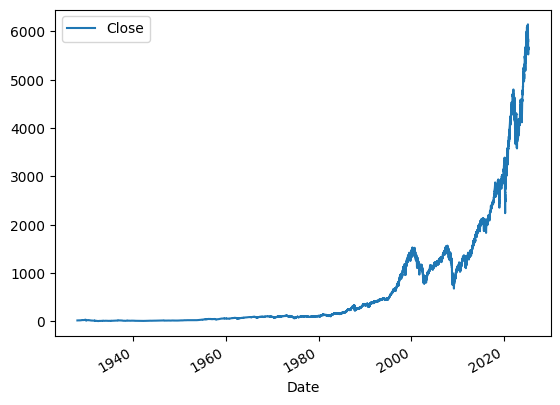

In [276]:
sp500.plot.line(y="Close", use_index=True)

In [277]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [278]:
sp500["Tomorrow"]=sp500["Close"].shift(-1)

In [279]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [280]:
sp500 = sp500.loc["2000-01-01":].copy()

In [281]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, min_samples_split=50, class_weight='balanced', random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(class_weight='balanced', min_samples_split=50,
                       n_estimators=200, random_state=1)

In [282]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.75

<Axes: xlabel='Date'>

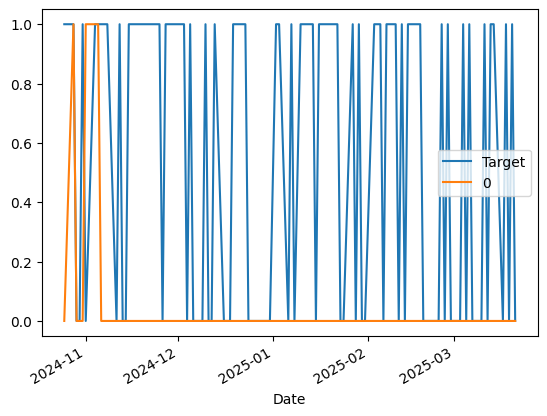

In [283]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [284]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:, 1]

    preds[preds >= 0.7] = 1
    preds[preds < 0.7] = 0

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [285]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [286]:
predictions = backtest(sp500, model, predictors)

In [287]:
predictions["Predictions"].value_counts()

Predictions
0.0    3655
1.0     188
Name: count, dtype: int64

In [288]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5691489361702128

In [289]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.545147
0    0.454853
Name: count, dtype: float64

In [290]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500.loc[:, ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
   
    sp500.loc[:, trend_column] = sp500["Target"].shift(1).rolling(horizon).sum()
    
    new_predictors += [ratio_column, trend_column]


In [291]:
sp500 = sp500.dropna()

In [292]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2003-12-26 00:00:00-05:00,1094.040039,1098.469971,1094.040039,1095.890015,356070000,1109.479980,1,1.000845,1.0,1.002176,3.0,1.039354,34.0,1.137825,135.0,0.957328,485.0
2003-12-29 00:00:00-05:00,1095.890015,1109.479980,1095.890015,1109.479980,1058800000,1109.640015,1,1.006162,2.0,1.010755,4.0,1.050761,34.0,1.150837,135.0,0.969445,486.0
2003-12-30 00:00:00-05:00,1109.479980,1109.750000,1106.410034,1109.640015,1012600000,1111.920044,1,1.000072,2.0,1.007835,4.0,1.049591,34.0,1.150046,135.0,0.969833,486.0
2003-12-31 00:00:00-05:00,1109.640015,1112.560059,1106.209961,1111.920044,1027500000,1108.479980,0,1.001026,2.0,1.006997,4.0,1.050463,34.0,1.151439,136.0,0.972073,486.0
2004-01-02 00:00:00-05:00,1111.920044,1118.849976,1105.079956,1108.479980,1153200000,1122.219971,1,0.998451,1.0,1.001263,4.0,1.046073,33.0,1.147024,135.0,0.969348,485.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-14 00:00:00-04:00,5563.850098,5645.270020,5563.850098,5638.939941,4863180000,5675.120117,1,1.010521,1.0,1.008885,2.0,0.948101,30.0,1.002164,141.0,1.218572,527.0
2025-03-17 00:00:00-04:00,5635.600098,5703.520020,5631.120117,5675.120117,5031770000,5614.660156,0,1.003198,2.0,1.013163,3.0,0.955252,30.0,1.008194,142.0,1.225923,528.0
2025-03-18 00:00:00-04:00,5654.529785,5654.529785,5597.759766,5614.660156,4666270000,5675.290039,1,0.994645,1.0,1.000847,3.0,0.946233,30.0,0.997123,141.0,1.212411,528.0


In [293]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [324]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.57] = 1
    preds[preds <.75] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [325]:
predictions = backtest(sp500, model, new_predictors)

In [326]:
predictions["Predictions"].value_counts()

Predictions
0.0    2025
1.0     817
Name: count, dtype: int64

In [327]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5422276621787026

In [329]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.539409
0    0.460591
Name: count, dtype: float64

In [328]:
predictions

,Target,Predictions
Date,,
2013-12-02 00:00:00-05:00,0,0.0
2013-12-03 00:00:00-05:00,0,0.0
2013-12-04 00:00:00-05:00,0,0.0
2013-12-05 00:00:00-05:00,1,0.0
2013-12-06 00:00:00-05:00,1,0.0
...,...,...
2025-03-14 00:00:00-04:00,1,0.0
2025-03-17 00:00:00-04:00,0,0.0
2025-03-18 00:00:00-04:00,1,1.0
